In [1]:
!pip install gitpython

In [2]:
import git
from tqdm import tqdm_notebook
import datetime as dt
import os
import re
import matplotlib.pyplot as plt
import datetime
import random
%matplotlib inline

In [4]:
! git clone https://github.com/elastic/elasticsearch.git

Cloning into 'elasticsearch'...
remote: Counting objects: 923645, done.
remote: Compressing objects: 100% (566/566), done.
remote: Total 923645 (delta 382), reused 405 (delta 170), pack-reused 922831
Receiving objects: 100% (923645/923645), 390.38 MiB | 22.53 MiB/s, done.
Resolving deltas: 100% (502704/502704), done.
Checking connectivity... done.


In [5]:
path = 'elasticsearch/'

In [6]:
class DiffObj:
    def __init__(self, diff):
        if diff[1].startswith('deleted'):
            self.mode = 'deleted'
            shift = 1
        elif diff[1].startswith('new'):
            self.mode = 'created'
            shift = 1
        else:
            self.mode = 'modificated'
            shift = 0
        self.index = diff[1 + shift][6:]
        self.file_old = diff[2 + shift][6:]
        self.file_new = diff[3 + shift][6:]
        lines = re.findall(r'@@.+@@', diff[4 + shift])[0][4:-3].split()
        self.range_minus, self.range_plus = lines[0], lines[1][1:]
        self.plus = [l[1:] for l in diff[(5 + shift):] if l[0] == '+']
        self.minus = [l[1:] for l in diff[(5 + shift):] if l[0] == '-']
        self.diff = diff



In [7]:
repo = git.Repo(path)

In [8]:
key_words = ['error', 'bug', 'fix', 'issue', 'mistake', 'incorrect', 'fault', 'defect', 'flaw', 'type']

In [9]:
commit = list(repo.iter_commits())[0]

In [10]:
all_commits = []
bug_commits = []
for commit in tqdm_notebook(repo.iter_commits()):
    all_commits.append(commit)
    try:
        if any([word in commit.message for word in key_words]):
            bug_commits.append(commit)
    except:
        print(commit.message)
print('all_commints:', len(all_commits))
print('bug_commints:', len(bug_commits))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


all_commints: 30515
bug_commints: 7120


In [11]:
years = [commit.committed_datetime.year for commit in bug_commits]

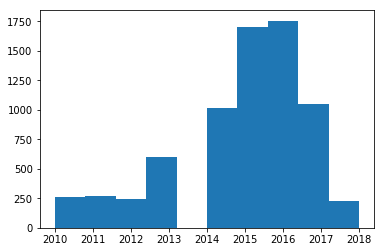

In [12]:
obj = plt.hist(years)
plt.savefig('commits_per_day.png', dpi=400)

In [13]:
date_range = [dt.date(2016, i, 1) for i in range(1, 13)] + [dt.date(2017,1, 1) ]

In [14]:
commit_by_month = []
for i in range(0, 12):
    print(date_range[i+1])
    commit_by_month.append([commit for commit in  bug_commits if ((commit.committed_datetime.date() < date_range[i+1]) and (commit.committed_datetime.date() > date_range[i]))])

2016-02-01
2016-03-01
2016-04-01
2016-05-01
2016-06-01
2016-07-01
2016-08-01
2016-09-01
2016-10-01
2016-11-01
2016-12-01
2017-01-01


In [15]:
cmd = 'cd {path}; git checkout master'.format(path=path)
os.system(cmd)

0

In [16]:
GLOBAL_DELETED = []
GLOBAL_TIME = date_range[-2]

In [17]:
wtf_commits = []

In [18]:
for i in tqdm_notebook(range(len(commit_by_month[-1])-1)):
    c0 = commit_by_month[-1][i]
    c1 = commit_by_month[-1][i+1]

    output = repo.git.diff(c1,c0).split('\n')
    diffs = []
    diff_file = []
    for l in output:
        if l.startswith('diff'):
            diffs.append(diff_file)
            diff_file = []
        diff_file.append(l)
    diffs = diffs[1:]
    try:
        diffs = [DiffObj(diff) for diff in diffs]
    except:
        diffs = [0]
    commit_date = c0.committed_datetime
    
    cmd = 'cd {path}; git checkout `git rev-list -n 1 --before="{time}" master`'.format(
                path=path, 
                time=str(commit_date - datetime.timedelta(minutes = 2)))
    os.system(cmd)

    
    good = 0
    bad = 0
    for diff in diffs:
        try:

            blame = []
            file = diff.file_old
            cmd = 'cd {path};git blame -f {fname}'.format(
                        path=path,
                        fname=file)
            with os.popen(cmd) as process:
                blame = process.readlines()
            code_time = dict()


            for b in blame:
                part1 = re.findall(r'.+\.java +', b)[0]
                part2 = re.findall(r'\(.+?\)', b)[0]
                time = re.findall(r'\d\d\d\d-\d\d-\d\d \d\d:\d\d:\d\d', part2)[0]
                time = datetime.datetime(int(time[0:4]), int(time[5:7]), int(time[8:10]), int(time[11:13]), int(time[14:16]), int(time[17:19]))
                code = b[len(part1)+len(part2) +1:-1]
                code_time[code] = time

            for line in diff.minus:
                good += 1
                if line in code_time and( code_time[line].date() < GLOBAL_TIME):
                    GLOBAL_DELETED.append(line)
                else:
                    bad += 1
        except:
            wtf_commits.append(c0)

HBox(children=(IntProgress(value=0, max=109), HTML(value='')))

In [19]:
print('GLOBAL_DELETED:', len(GLOBAL_DELETED))

GLOBAL_DELETED: 17440


In [20]:
with open('GLOBAL_DELETED_' + str(GLOBAL_TIME), 'w') as file:
    for line in GLOBAL_DELETED:
        file.write(line + '\n')

In [21]:
GLOBAL_ADDED = []

In [22]:
for i in tqdm_notebook(range(len(commit_by_month[-1])-1)):
    c0 = commit_by_month[-1][i]
    c1 = commit_by_month[-1][i+1]

    output = repo.git.diff(c1,c0).split('\n')
    diffs = []
    diff_file = []
    for l in output:
        if l.startswith('diff'):
            diffs.append(diff_file)
            diff_file = []
        diff_file.append(l)
    diffs = diffs[1:]
    try:
        diffs = [DiffObj(diff) for diff in diffs]
    except:
        diffs = [0]
    for diff in diffs:
        try:
            GLOBAL_ADDED.extend(diff.plus)
        except:
            pass

HBox(children=(IntProgress(value=0, max=109), HTML(value='')))

In [23]:
print('GLOBAL_ADDED:', len(GLOBAL_ADDED))

GLOBAL_ADDED: 62508


In [24]:
with open('GLOBAL_ADDED_' + str(GLOBAL_TIME), 'w') as file:
    for line in GLOBAL_ADDED:
        file.write(line + '\n')